# Lecture 20: Ethics

from
> https://github.com/UBC-CS/cpsc330

## Imports

In [1]:
import os
import sys

import IPython
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from IPython.display import Image, HTML, display
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

%matplotlib inline
pd.set_option("display.max_colwidth", 200)
plt.rcParams["font.size"] = 16  # for confusion matrices

<br><br>

## ML fairness activity

AI/ML systems can give the illusion of objectivity as they are derived from seemingly unbiased data & algorithms. However, human beings are inherently biased and AI/ML systems, if not carefully evaluated, can even further ***amplify* the existing inequities** and systemic bias in our society.  

- How do we make sure our AI/ML systems are **fair**?
- Which metrics can we use to **quantify 'fairness'** in AI/ML systems?

Let's examine this on [the adult census data set](https://www.kaggle.com/uciml/adult-census-income). 

In [2]:
census_df = pd.read_csv("data/adult.csv")
census_df.shape

(32561, 15)

In [3]:
train_df, test_df = train_test_split(census_df, test_size=0.4, random_state=42)

In [4]:
train_df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
25823,36,Private,245521,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,35,Mexico,<=50K
10274,26,Private,134287,Assoc-voc,11,Never-married,Sales,Own-child,White,Female,0,0,35,United-States,<=50K
27652,25,Local-gov,109526,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,38,United-States,<=50K
13941,23,Private,131275,HS-grad,9,Never-married,Craft-repair,Own-child,Amer-Indian-Eskimo,Male,0,0,40,United-States,<=50K
31384,27,Private,193122,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,25,Private,410240,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
5390,51,Private,146767,Assoc-voc,11,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K
860,55,Federal-gov,238192,HS-grad,9,Married-civ-spouse,Tech-support,Husband,White,Male,0,1887,40,United-States,>50K
15795,41,Private,154076,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,50,United-States,>50K


In [5]:
train_df_nan = train_df.replace("?", np.nan)
test_df_nan = test_df.replace("?", np.nan)
train_df_nan.shape

(19536, 15)

In [6]:
# Let's identify numeric and categorical features

numeric_features = [
    "age",
    "fnlwgt",
    "capital.gain",
    "capital.loss",
    "hours.per.week",
]

categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    # "race",
    "native.country",
]

ordinal_features = ["education"]
binary_features = [
    "sex"
]  # Not binary in general but in this particular dataset it seems to have only two possible values
drop_features = ["education.num"]
target = "income"

In [7]:
train_df["education"].unique()

array(['7th-8th', 'Assoc-voc', 'HS-grad', 'Bachelors', 'Some-college',
       '10th', '11th', 'Prof-school', '12th', '5th-6th', 'Masters',
       'Assoc-acdm', '9th', 'Doctorate', '1st-4th', 'Preschool'],
      dtype=object)

In [8]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [9]:
assert set(education_levels) == set(train_df["education"].unique())

In [10]:
X_train = train_df_nan.drop(columns=[target])
y_train = train_df_nan[target]

X_test = test_df_nan.drop(columns=[target])
y_test = test_df_nan[target]

In [11]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

numeric_transformer = make_pipeline(StandardScaler())

ordinal_transformer = OrdinalEncoder(categories=[education_levels], dtype=int)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)

In [12]:
y_train.value_counts().to_frame().assign(ratio=y_train.value_counts(normalize=True))

,income,ratio
<=50K,14841,0.759674
>50K,4695,0.240326


In [13]:
pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(class_weight="balanced", max_iter=1000)
)

In [14]:
pipe_lr.fit(X_train, y_train);

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

kw_cm = dict(normalize="true", cmap=plt.cm.Blues) # key-word arguments for all confusion matrices
kw_cm

{'normalize': 'true',
 'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x24270b59f40>}

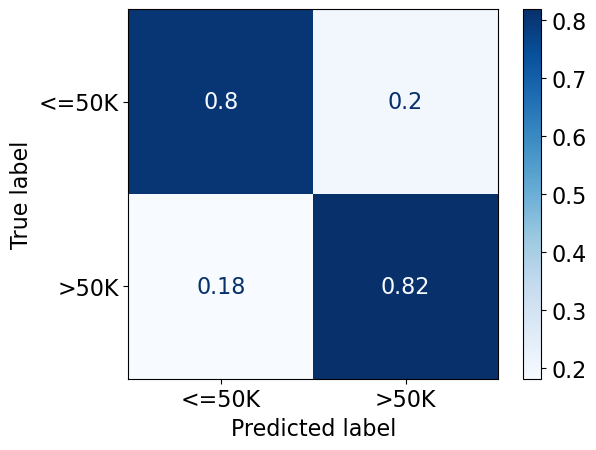

In [16]:
ConfusionMatrixDisplay.from_estimator(pipe_lr, X_test, y_test, **kw_cm);

Let's examine confusion matrix separately for the two genders we have in the data. 

In [17]:
pipe_lr[0].named_transformers_['pipeline-2']['onehotencoder'].get_feature_names_out(['sex'])

array(['sex_Male'], dtype=object)

In [18]:
X_test.head(3)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
14160,29,Private,280618,Some-college,10,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
27048,19,Private,439779,Some-college,10,Never-married,Sales,Own-child,White,Male,0,0,15,United-States
28868,28,Private,204734,Some-college,10,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,40,United-States


In [19]:
X_female = X_test.query("sex=='Female'")
X_male = X_test.query("sex=='Male'")

y_female = y_test[X_female.index]
y_male = y_test[X_male.index]

female_preds = pipe_lr.predict(X_female)
male_preds = pipe_lr.predict(X_male)

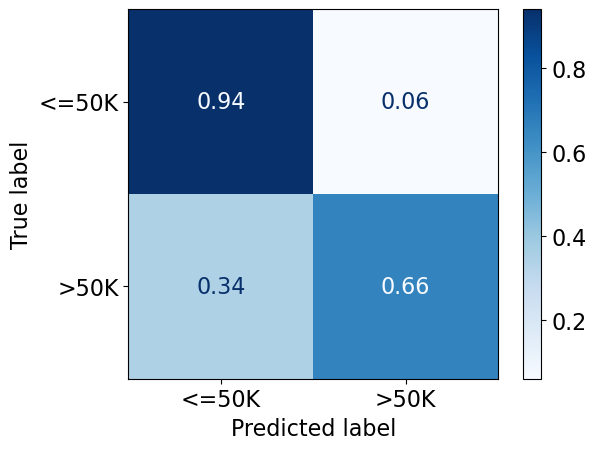

In [20]:
ConfusionMatrixDisplay.from_predictions(y_female, female_preds, **kw_cm);

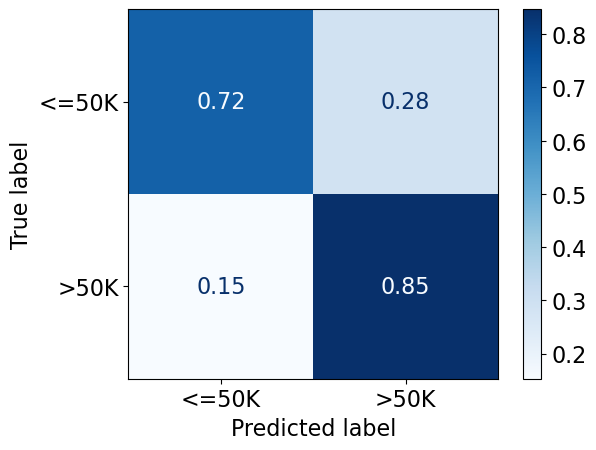

In [21]:
ConfusionMatrixDisplay.from_predictions(y_male, male_preds, **kw_cm);

<br>

In [22]:
from sklearn.metrics import confusion_matrix

f_TN, f_FP, f_FN, f_TP = confusion_matrix(y_female, female_preds).ravel()
m_TN, m_FP, m_FN, m_TP = confusion_matrix(y_male, male_preds).ravel()

<br><br>

What's the accuracy of this model? 

In [23]:
data = {"male": {}, "female": {}}

In [24]:
accuracy_male = accuracy_score(y_male, male_preds)
accuracy_female = accuracy_score(y_female, female_preds)

data["male"]['accuracy'] = accuracy_male
data["female"]['accuracy'] = accuracy_female

print(f"Accuracy male: {accuracy_male:.3f}")
print(f"Accuracy female: {accuracy_female:.3f}")

Accuracy male: 0.756
Accuracy female: 0.909


<br>

In [25]:
pd.DataFrame({
    "both": y_test.value_counts(normalize=True),
    "female": y_female.value_counts(normalize=True),
    "male": y_male.value_counts(normalize=True)
})

,both,female,male
<=50K,0.758464,0.892675,0.691999
>50K,0.241536,0.107325,0.308001


There is more class imbalance for female! 

**As an example**, let's assume that a company is using **this classifier for loan approval** with a simple rule that:
- if the income is >50K, approve the loan, else reject the loan.

**Statistical parity** suggests that the proportion of each segment of a protected class (e.g. sex) should receive the positive outcome at equal rates. For example, the number of loans approved for female should be equal to male.

Calculate the precision for male and female.

In [26]:
precision_male = precision_score(y_male, male_preds, pos_label=">50K")
precision_female = precision_score(y_female, female_preds, pos_label=">50K")

data["male"]['precision'] = precision_male
data["female"]['precision'] = precision_female

print("Precision male: {:.3f}".format(precision_male))
print("Precision female: {:.3f}".format(precision_female))

Precision male: 0.570
Precision female: 0.567


<br>

In [27]:
pd.DataFrame({
    'count': [len(y_male), len(y_female)],
    'positive outcome': [m_TP + m_FP, f_TP + f_FP],
    'proportion': [(m_TP + m_FP) / len(y_male), (f_TP + f_FP) / len(y_female)],
}, index=['male', 'female'])

,count,positive outcome,proportion
male,8711,3986,0.457582
female,4314,536,0.124247


<br>
Based on your results, do you think this income classifier is fair?

<br><br>

**Equal opportunity** suggests that each group should get the positive outcome at equal rates, assuming that people in this group qualify for it. For example, if a man and a woman have both a certain level of income, we want them to have the same chance of getting the loan. In other words, the true positive rate (TPR or recall) of both groups should be equal.

In [28]:
recall_male = recall_score(y_male, male_preds, pos_label=">50K")
recall_female = recall_score(y_female, female_preds, pos_label=">50K")

data["male"]['recall'] = recall_male
data["female"]['recall'] = recall_female

print("Recall male: {:.3f}".format(recall_male))
print("Recall female: {:.3f}".format(recall_female))

Recall male: 0.847
Recall female: 0.657


<br><br>

There is usually a trade-off between rationality (adopting effective means to achieve your desired outcome) and bias (in system). The desired outcome of banks, for example, is to maximize their profit. So in many circumstances, they not only care about approving as many qualified applications as possible (true positive), but also to avoid approving unqualified applications (false positive) because default loan could have detrimental effects for them. 

Let's examine false positive rate (FPR) of both groups.

In [29]:
fpr_male = m_FP / (m_FP + m_TN)
fpr_female = f_FP / (f_FP + f_TN)

data["male"]['FPR'] = fpr_male
data["female"]['FPR'] = fpr_female

print("FPR male: {:.3f}".format(fpr_male))
print("FPR female: {:.3f}".format(fpr_female))

FPR male: 0.284
FPR female: 0.060


<br>

In [30]:
pd.DataFrame(data).T

,accuracy,precision,recall,FPR
male,0.756285,0.570246,0.847186,0.284174
female,0.909365,0.567164,0.656587,0.060244


- Discuss these results with your neighbours. 
- Does the effect still exist if the sex feature is removed from the model (but you still have it available separately to do the two confusion matrices)? 

<br><br><br><br>

## Ethical issues in Boston housing dataset

Let us now look at another example dataset with ethical issues which is currently a built in`sklearn` dataset: the Boston Housing dataset. The sklearn documentation says it "will be removed in 1.2" (see below).

You can read this [Medium article by M Carlisle: "racist data destruction?"](https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8)

> When I say “systemic racism” here, I mean this mathematically. This is a term, in a statistical model to predict housing prices, that accounts for racism as a factor in pricing. If this is used to predict, or even influence future models by its very existence, then systemic racism will continue to be a pricing factor.

The following is quoted from `sklearn.datasets.load_boston()` documentation:

```
Signature: load_boston(*, return_X_y=False)
Docstring:
DEPRECATED: `load_boston` is deprecated in 1.0 and will be removed in 1.2.

The Boston housing prices dataset has an ethical problem. You can refer to
the documentation of this function for further details.

The scikit-learn maintainers therefore strongly discourage the use of this
dataset unless the purpose of the code is to study and educate about
ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np


    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset (i.e.
:func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.


Load and return the boston house-prices dataset (regression).

==============   ==============
Samples total               506
Dimensionality               13
Features         real, positive
Targets           real 5. - 50.
==============   ==============

Read more in the :ref:`User Guide <boston_dataset>`.

.. deprecated:: 1.0
   This function is deprecated in 1.0 and will be removed in 1.2. See the
   warning message below for further details regarding the alternative
   datasets.

.. warning::
    The Boston housing prices dataset has an ethical problem: as
    investigated in [1]_, the authors of this dataset engineered a
    non-invertible variable "B" assuming that racial self-segregation had a
    positive impact on house prices [2]_. Furthermore the goal of the
    research that led to the creation of this dataset was to study the
    impact of air quality but it did not give adequate demonstration of the
    validity of this assumption.

    The scikit-learn maintainers therefore strongly discourage the use of
    this dataset unless the purpose of the code is to study and educate
    about ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd  # doctest: +SKIP
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset [3]_
    (i.e. :func:`~sklearn.datasets.fetch_california_housing`) and Ames
    housing dataset [4]_. You can load the datasets as follows::

        from sklearn.datasets import fetch_california_housing
        housing = fetch_california_housing()

    for the California housing dataset and::

        from sklearn.datasets import fetch_openml
        housing = fetch_openml(name="house_prices", as_frame=True)  # noqa

    for the Ames housing dataset.

Parameters
----------
return_X_y : bool, default=False
    If True, returns ``(data, target)`` instead of a Bunch object.
    See below for more information about the `data` and `target` object.

    .. versionadded:: 0.18

Returns
-------
data : :class:`~sklearn.utils.Bunch`
    Dictionary-like object, with the following attributes.

    data : ndarray of shape (506, 13)
        The data matrix.
    target : ndarray of shape (506,)
        The regression target.
    filename : str
        The physical location of boston csv dataset.

        .. versionadded:: 0.20

    DESCR : str
        The full description of the dataset.
    feature_names : ndarray
        The names of features

(data, target) : tuple if ``return_X_y`` is True

    .. versionadded:: 0.18

Notes
-----
    .. versionchanged:: 0.20
        Fixed a wrong data point at [445, 0].

References
----------
.. [1] `Racist data destruction? M Carlisle,
        <https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>`_
.. [2] `Harrison Jr, David, and Daniel L. Rubinfeld.
       "Hedonic housing prices and the demand for clean air."
       Journal of environmental economics and management 5.1 (1978): 81-102.
       <https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>`_
.. [3] `California housing dataset
        <https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset>`_
.. [4] `Ames housing dataset
        <https://www.openml.org/d/42165>`_

Examples
--------
>>> import warnings
>>> from sklearn.datasets import load_boston
>>> with warnings.catch_warnings():
...     # You should probably not use this dataset.
...     warnings.filterwarnings("ignore")
...     X, y = load_boston(return_X_y=True)
>>> print(X.shape)
(506, 13)
File:      ~/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/datasets/_base.py
Type:      function
```

<br><br>

The following is quoted from the original dataset URL:

 &nbsp; &nbsp; http://lib.stat.cmu.edu/datasets/boston

```
 The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
 prices and the demand for clean air', J. Environ. Economics & Management,
 vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
 ...', Wiley, 1980.   N.B. Various transformations are used in the table on
 pages 244-261 of the latter.

 Variables in order:
 CRIM     per capita crime rate by town
 ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
 INDUS    proportion of non-retail business acres per town
 CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 NOX      nitric oxides concentration (parts per 10 million)
 RM       average number of rooms per dwelling
 AGE      proportion of owner-occupied units built prior to 1940
 DIS      weighted distances to five Boston employment centres
 RAD      index of accessibility to radial highways
 TAX      full-value property-tax rate per $10,000
 PTRATIO  pupil-teacher ratio by town
 B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
 LSTAT    % lower status of the population
 MEDV     Median value of owner-occupied homes in $1000's
```

<br><br>

## Dynamics of Ethical Issues!

What are __our__ "___systemic *isms___" today?

<br><br>